Leon Yin, Davey Alba and Leonardo Nicoletti with the Bloomberg Graphics team put together an incredible piece on [racial bias in ChatGPT](https://www.bloomberg.com/graphics/2024-openai-gpt-hiring-racial-discrimination/) by measuring how OpenAI's model ranked resume's for different jobs. Using name as signal, they found very strong race and gender effects that varied by occupation. I suspect that an expanded replication would be a great fit with many top social science journals.

One part that interested me was the figure they created that showed how OpenAI's word embeddings cluster names by race

![](bloomberg.png)

I wanted to recreate that. Fortunately, they [posted their code on GitHub](https://github.com/BloombergGraphics/2024-openai-gpt-hiring-racial-discrimination). The [word embeddings](https://github.com/BloombergGraphics/2024-openai-gpt-hiring-racial-discrimination/blob/main/notebooks/3-word-embeddings.ipynb) didn't run as written, but I was able to get it up an running with a few modifications. 

They studied a now slightly-out-of-date embedding model, `text-embedding-ada-002`, so I also wanted to extend their work to look at the new models `text-embedding-3-small` and `text-embedding-3-large.`

In [1]:
import json

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex

import pandas as pd
import numpy as np
import umap
from openai import OpenAI
import warnings

# Suppress all UserWarnings because umap is annoying
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
def load_and_prep_names(file_path, sex):
    df = pd.read_json(file_path)
    melted_df = pd.melt(df, var_name="race", value_name="name")
    melted_df.dropna(inplace=True)
    melted_df.reset_index(drop=True, inplace=True)
    melted_df["sex"] = sex
    return melted_df


# File paths
fn_names_men = "https://raw.githubusercontent.com/BloombergGraphics/2024-openai-gpt-hiring-racial-discrimination/main/data/input/top_mens_names.json"
fn_names_women = "https://raw.githubusercontent.com/BloombergGraphics/2024-openai-gpt-hiring-racial-discrimination/main/data/input/top_womens_names.json"

# Load and prepare data
names_men = load_and_prep_names(fn_names_men, "M")
names_women = load_and_prep_names(fn_names_women, "W")

# Combine and title-case names - Original used all upper case
name_df = pd.concat([names_men, names_women])
name_df["name"] = name_df["name"].str.title()

# Now, name_df is ready and contains the processed names with races and sex indicators.
name_df.sample(5)

,race,name,sex
114,B,Darnell Jackson,M
59,W,Katie Schwartz,W
42,W,Jaclyn Reilly,W
304,H,Alex Barajas,M
107,B,Ayanna Singleton,W


Next, I get the embeddings for the three models of interest. `text-embedding-ada-002` and `text-embedding-3-small` but represent texts in 1,536 dimensions, while `text-embedding-3-large` has twice as many. This is hard to plot, so, following the good folks at Bloomberg, I use UMAP to reduce this down to just two dimensions for each embedding model. I also tried a different algorithm, TSNE with very similar results. 

In [8]:
def get_open_embeddings(text_list, model="text-embedding-3-small"):
    client = OpenAI(max_retries=3)
    """Fetches embeddings for a list of texts using the specified model."""
    embeddings_response = client.embeddings.create(input=text_list, model=model)
    return [text.embedding for text in embeddings_response.data]


def reduce_dimensions(
    df, embedding_column, n_components=2, random_state=42, n_neighbors=30, min_dist=0.9
):
    """Reduces the dimensions of embeddings to 2D using UMAP."""
    embeddings = np.vstack(df[embedding_column])
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    df[f"{embedding_column}_umap_x"], df[f"{embedding_column}_umap_y"] = (
        reduced_embeddings.T
    )
    return df


# Main code
for model in [
    "text-embedding-ada-002",
    "text-embedding-3-small",
    "text-embedding-3-large",
]:

    if model not in name_df.keys():
        names = name_df["name"].tolist()
        name_df[model] = get_open_embeddings(names, model=model)
    name_df = reduce_dimensions(name_df, model)

Finally, plot them. I added gender to the mix by showing women's names with a darker hue.

In [11]:
# Function to darken a color
def darken_color(color, factor=0.7):
    # Convert to RGBA if it's a named color or in hex format
    rgba_color = to_rgba(color)
    # Darken by reducing the brightness
    darkened = [factor * rgb for rgb in rgba_color[:3]] + [rgba_color[3]]
    return to_hex(darkened)


# Base colors for races
race2color = {
    "W": "#c71e1d",
    "B": "#fa8c00",
    "A": "#009076",
    "H": "#15607a",
    "CTRL": "grey",
}

def plot_names(model):
    # Extend race2color with darker shades for females
    race2color_female = {race: darken_color(color) for race, color in race2color.items()}

    # Extract UMAP coordinates, names, races, and sexes
    umap_x = name_df[f"{model}_umap_x"].values
    umap_y = name_df[f"{model}_umap_y"].values
    names = name_df["name"].values
    races = name_df["race"].values
    sexes = name_df["sex"].values

    # Determine color based on race and sex
    colors = [
        race2color_female[race] if sex == "W" else race2color[race]
        for race, sex in zip(races, sexes)
    ]

    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.scatter(umap_x, umap_y, color=colors, alpha=0.5)

    # Annotate each point with the corresponding name
    for x, y, name, color in zip(umap_x, umap_y, names, colors):
        ax.annotate(name, (x, y), color=color, size=8, ha="center", va="bottom")

    # Enhancements
    ax.set_title(f"UMAP projection of {model} Embeddings by Race and Sex", fontsize=16)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

    # Optional: Remove the x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

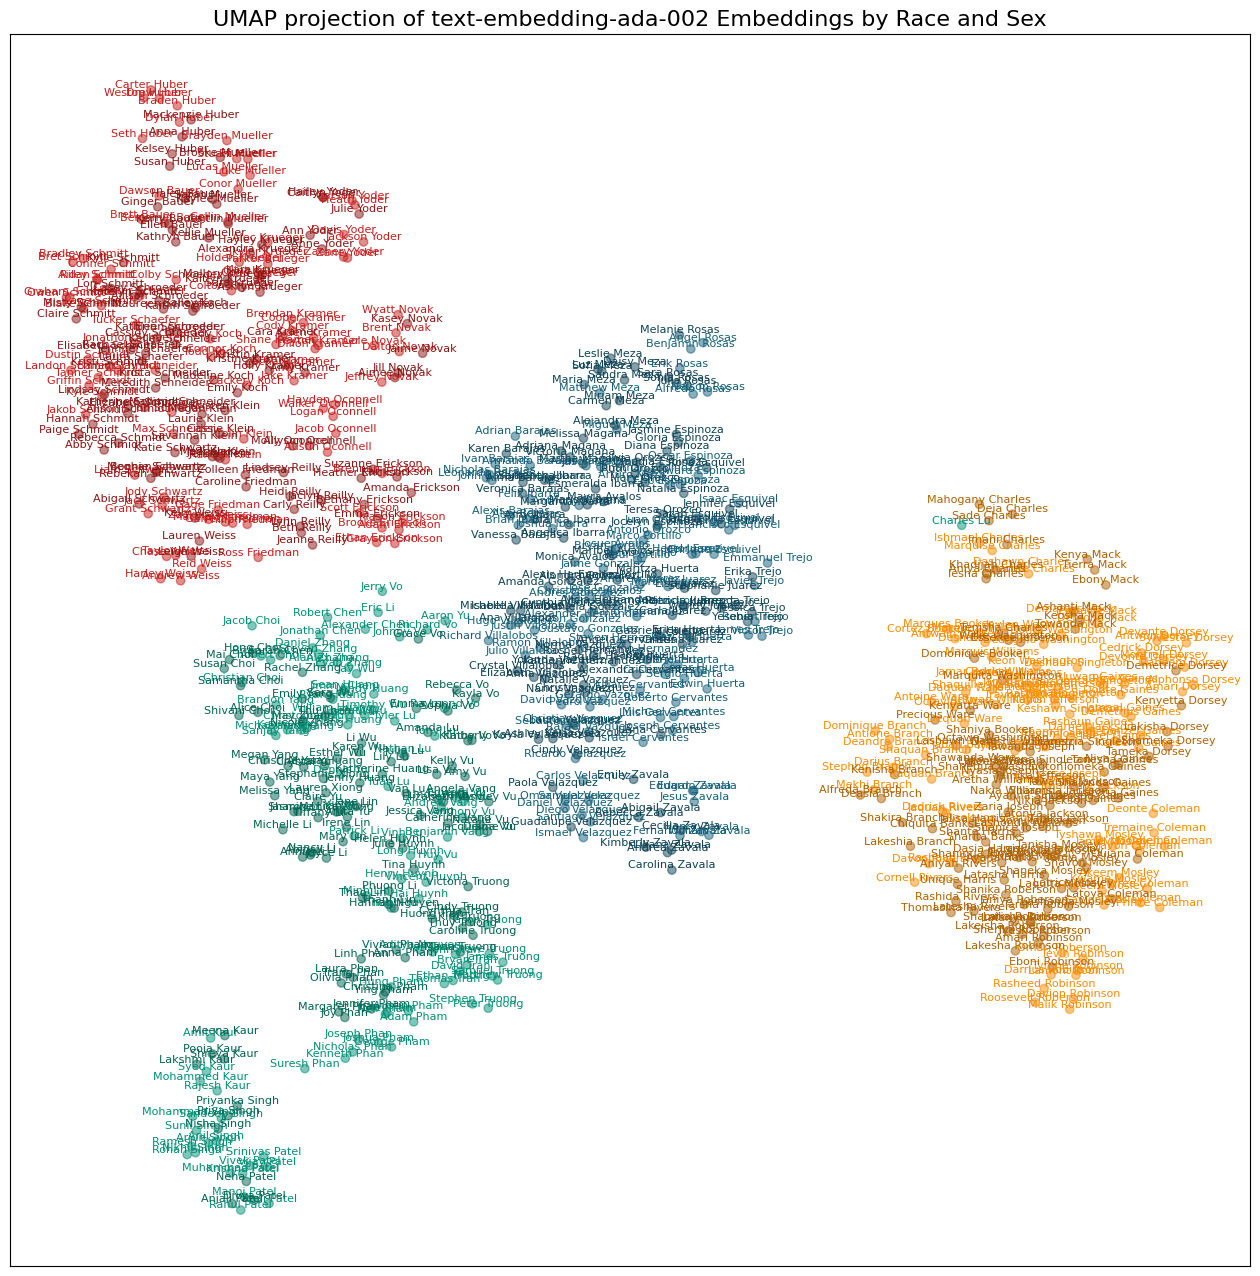

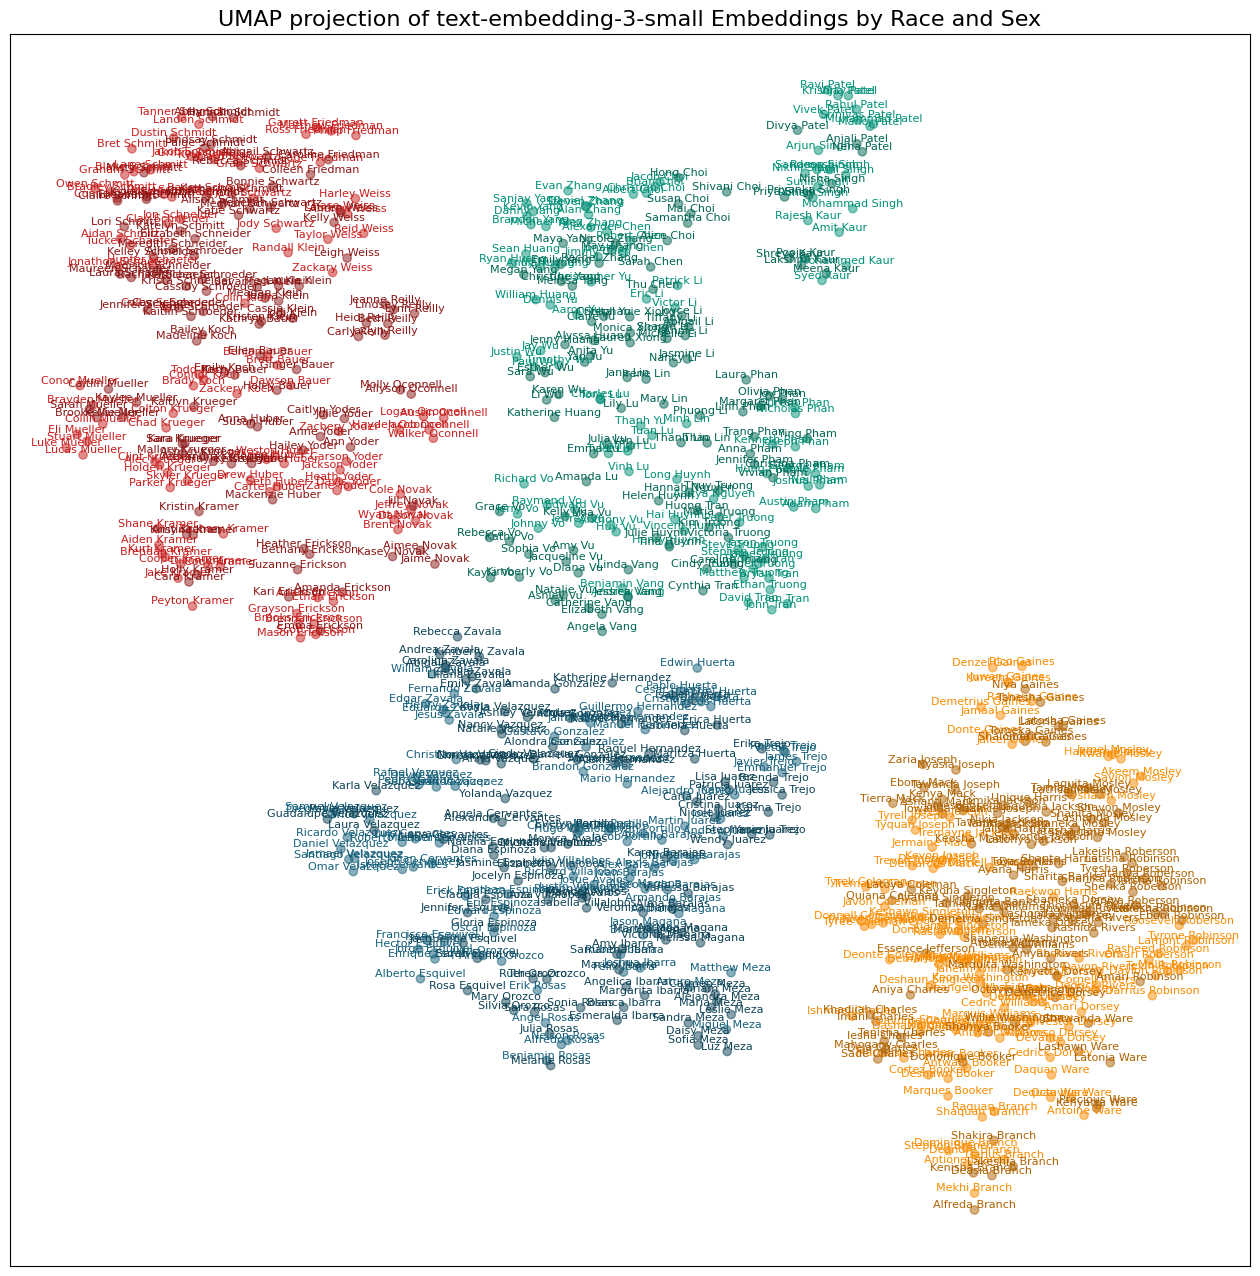

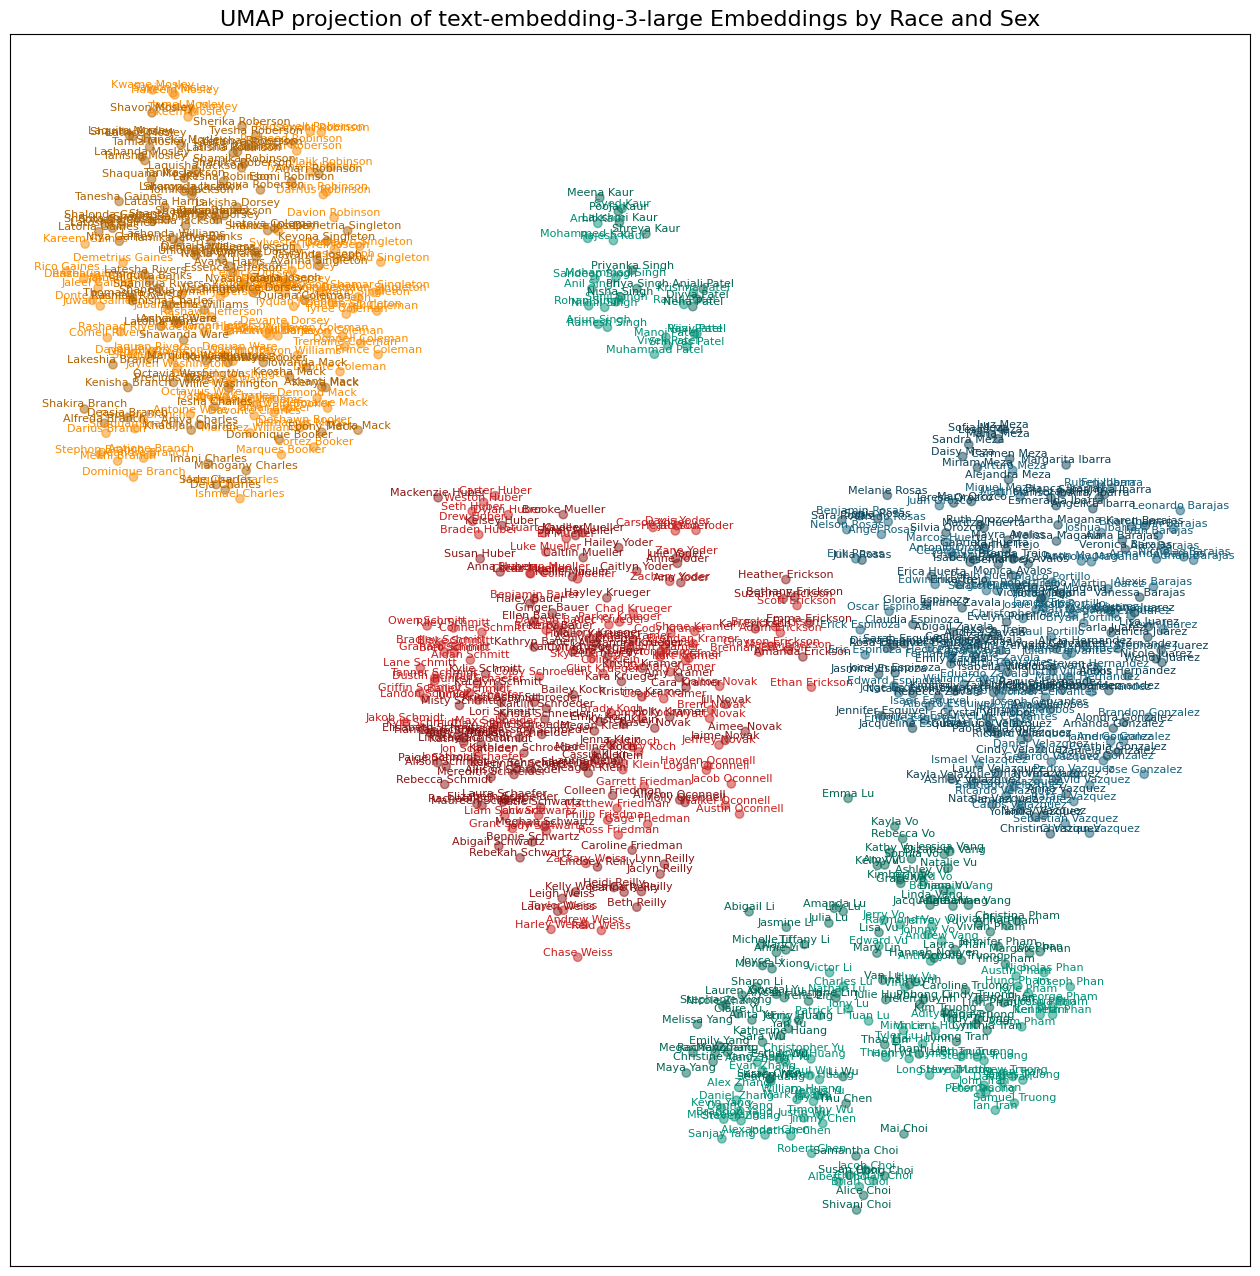

In [12]:
for model in ['text-embedding-ada-002', 'text-embedding-3-small', 'text-embedding-3-large']:
    plot_names(model)

All three models show racial clusters with very few outliers. I suspect the differences in the distances between the clusters is a function of the UMAP process of reducing 1K+ dimensions down to two, but maybe not. One notable difference is that while all three clustered the South Asian names together, the `text-embedding-3-large` had the Patels and Singhs off on their own. 

Notably, the names aren't clustering by gender to the same degree as race. It appears to me that the last names are running the show in two dimensions. I haven't test this, but it does look like there is some clustering by gender within racial clusters, although this varies by embedding model and by racial group.  

I *thought* it would be fruitful to look at using the name embeddings as features in machine learning to predict race, but, after running the model a few times, I realized this was the wrong dataset to test that out on. While it has 800 unique cases, it only has 20 unique last names for each racial group, so it's really easy to overfit the model.  But since I put together the code here it is:

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Assuming 'name_df' is your DataFrame and it already includes the embedding features
# and the 'race' column.

# Function to train and evaluate an SVM classifier for a given set of embeddings
def train_and_evaluate_svm(df, feature_column, target_column):
    # Split data into features (X) and target (y)
    X = np.vstack(df[feature_column])  # Ensure the embeddings are in the correct format
    y = df[target_column].values
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the SVM classifier
    clf = SVC(kernel='linear', C=1.0, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate the classifier
    report = classification_report(y_test, y_pred)
    return report

# List of embedding columns in your DataFrame
embedding_columns = ['text-embedding-ada-002', 'text-embedding-3-small', 'text-embedding-3-large']

# Evaluate the classifier for each set of embeddings
for embedding in embedding_columns:
    print(f"Evaluating SVM with embeddings: {embedding}")
    report = train_and_evaluate_svm(name_df, embedding, 'race')
    print(report)


Evaluating SVM with embeddings: text-embedding-ada-002
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        42
           B       1.00      0.97      0.99        35
           H       1.00      1.00      1.00        46
           W       0.97      1.00      0.99        37

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

Evaluating SVM with embeddings: text-embedding-3-small
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        42
           B       1.00      1.00      1.00        35
           H       1.00      1.00      1.00        46
           W       1.00      1.00      1.00        37

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Evaluating SVM with 

Back when I thought it would be useful, I also tried to model how many embedding dimensions it would take, leveraging the fact that the two new OpenAI models apparently put all the interesting ones up from. Results do seem to confirm that, but again, with only 20 last names, I don't make too much of this.

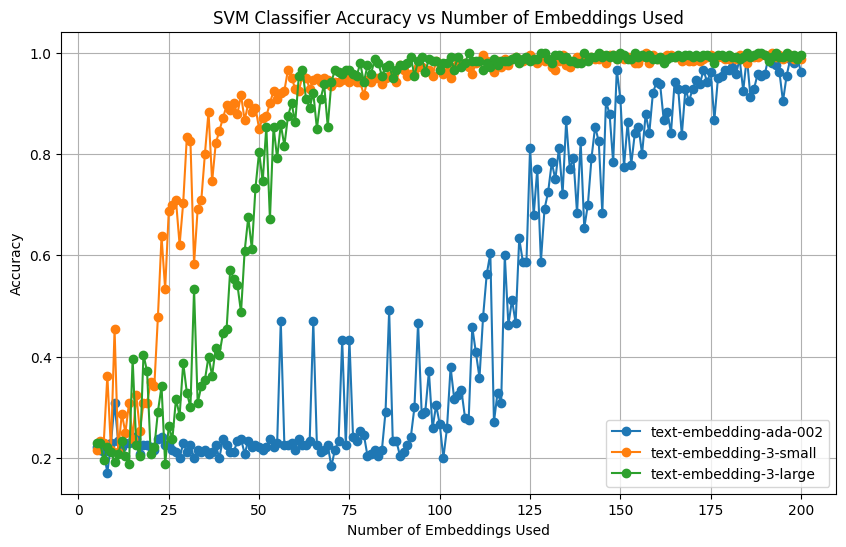

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'name_df' is your DataFrame and it includes both the embedding feature
# 'text-embedding-3-small' and the 'race' column.

# Function to train and evaluate an SVM classifier for a given number of embeddings
def train_and_evaluate_svm(df, embeddings_column, target_column, max_columns):
    # Initialize list to store accuracy scores
    accuracies = []
    columns_used = []
    
    for num_embeddings in range(5, max_columns + 1, 1):
        # Extract the first 'num_embeddings' from each row in the embeddings column
        X = np.array(df[embeddings_column].apply(lambda x: x[:num_embeddings]).tolist())
        y = df[target_column].values

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        
        # Initialize and train the SVM classifier
        clf = SVC(kernel='linear', C=1.0, random_state=42)
        clf.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = clf.predict(X_test)
        
        # Calculate and store the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        columns_used.append(num_embeddings)
    
    return accuracies, columns_used

# Assuming 'text-embedding-3-small' contains embeddings and 'race' is the target column
# Also assuming each embedding in 'text-embedding-3-small' has at least 200 dimensions
plt.figure(figsize=(10, 6))

colors = ['b', 'g', 'r']  # Define a list of colors if you want specific colors for each model
model_names = ['text-embedding-ada-002','text-embedding-3-small', 'text-embedding-3-large']
# Alternatively, remove the colors list and Matplotlib will automatically assign colors.

for i, model in enumerate(model_names):
    accuracies, columns_used = train_and_evaluate_svm(name_df, model, 'race', 200)

    # Plotting the accuracy vs. number of embeddings used
    # If using automatic colors, just remove the color argument
    plt.plot(columns_used, accuracies, marker='o', linestyle='-', label=model)

plt.title('SVM Classifier Accuracy vs Number of Embeddings Used')
plt.xlabel('Number of Embeddings Used')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()  # This adds the legend using the labels specified in plt.plot()
plt.show()

Future directions:
* Use a different dataset for racial classification by name.
* Subtract the overall average name vectors from the average name vector by race to get a race vector?
* Redo the Bloomberg audi study, but use ChatGPT to create the resumes, and then rank them, either with different names or without names.